# 1. Import Libraries and Load Dataset

In [2]:

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pickle
import os

# Load the dataset
csv_path = os.path.join("../dataset/Student-Spending-Habits_PreProcessed.csv")
df = pd.read_csv(csv_path)

# Target columns
expense_cols = ["Living_Expenses", "Food_and_Dining_Expenses", 
                "Transportation_Expenses", "Leisure_and_Entertainment_Expenses", "Academic_Expenses"]

# Separate features and targets
X = df.drop(columns=expense_cols)
y = df[expense_cols]


# 2. Split Dataset

In [3]:

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 3. Hyperparameter Tuning with RandomizedSearchCV

In [4]:

param_grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features': ['sqrt', 'log2', None, 10],
}

base_rf = RandomForestRegressor(random_state=2)

random_search = RandomizedSearchCV(estimator=base_rf,
                                   param_distributions=param_grid,
                                   n_iter=20,
                                   scoring='r2',
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1,
                                   random_state=42)

multioutput_regressor_search = MultiOutputRegressor(random_search)
multioutput_regressor_search.fit(X_train, Y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


MultiOutputRegressor(estimator=RandomizedSearchCV(cv=3,
                                                  estimator=RandomForestRegressor(random_state=2),
                                                  n_iter=20, n_jobs=-1,
                                                  param_distributions={'max_depth': [None,
                                                                                     10,
                                                                                     20,
                                                                                     30],
                                                                       'max_features': ['sqrt',
                                                                                        'log2',
                                                                                        None,
                                                                                        10],
                                                                       'min_samples_leaf': [1,
                                                                                            5,
                                                                                            10,
                                                                                            20],
                                                                       'min_samples_split': [2,
                                                                                             5,
                                                                                             10],
                                                                       'n_estimators': [100,
                                                                                        250,
                                                                                        500]},
                                                  random_state=42, scoring='r2',
                                                  verbose=2))

# 4. Train with Best Hyperparameters Found

In [5]:

# Extract best estimators for each target
best_estimators = [est.best_estimator_ for est in multioutput_regressor_search.estimators_]

# Print each best estimator
for idx, estimator in enumerate(best_estimators):
    print(f"Best estimator for target {idx + 1}:")
    print(estimator)
    print("-" * 50)

# Use average or most common best parameters manually (simplified)
final_rf = RandomForestRegressor(n_estimators=250, min_samples_leaf=5, min_samples_split=2,
                                 max_features=None, max_depth=None, random_state=2)

multioutput_regressor = MultiOutputRegressor(final_rf)
multioutput_regressor.fit(X_train, Y_train)


Best estimator for target 1:
RandomForestRegressor(max_features=None, min_samples_leaf=5, n_estimators=250,
                      random_state=2)
--------------------------------------------------
Best estimator for target 2:
RandomForestRegressor(max_features=None, min_samples_leaf=5, n_estimators=250,
                      random_state=2)
--------------------------------------------------
Best estimator for target 3:
RandomForestRegressor(max_features=None, min_samples_leaf=5, n_estimators=250,
                      random_state=2)
--------------------------------------------------
Best estimator for target 4:
RandomForestRegressor(max_depth=30, max_features='log2', n_estimators=500,
                      random_state=2)
--------------------------------------------------
Best estimator for target 5:
RandomForestRegressor(max_features=None, min_samples_leaf=5, n_estimators=250,
                      random_state=2)
--------------------------------------------------


MultiOutputRegressor(estimator=RandomForestRegressor(max_features=None,
                                                     min_samples_leaf=5,
                                                     n_estimators=250,
                                                     random_state=2))

# 5. Evaluate Model

In [6]:

Y_pred = multioutput_regressor.predict(X_test)

r2 = r2_score(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)

print("R2 Score:", r2)
print("Mean Absolute Error:", mae)


R2 Score: 0.8658774894863193
Mean Absolute Error: 775.1782032404079


# 6. Feature Importance Plots

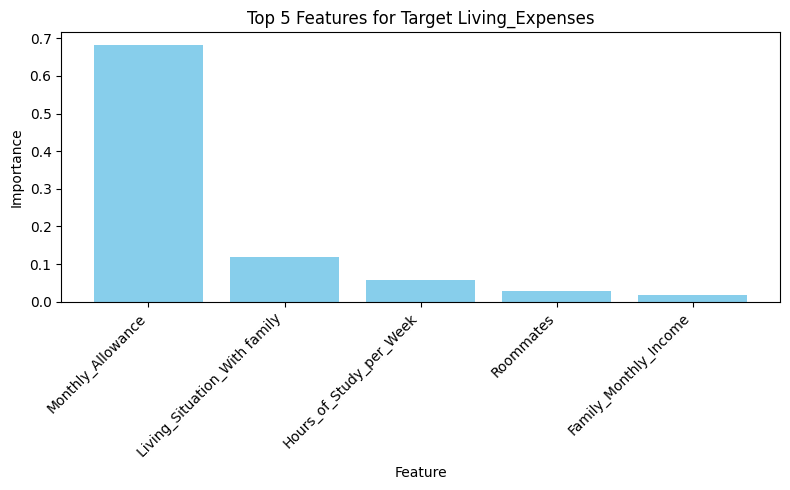

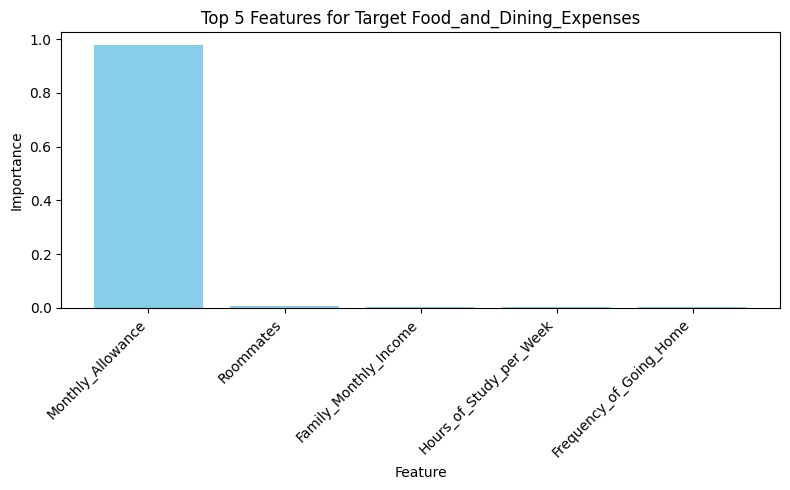

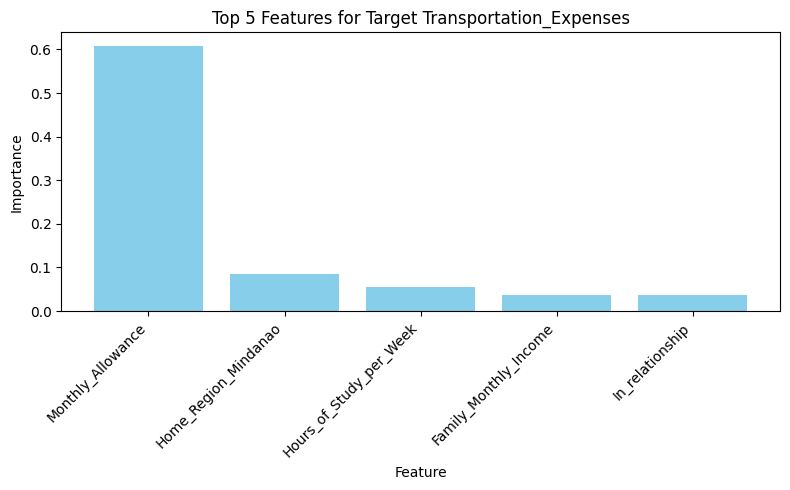

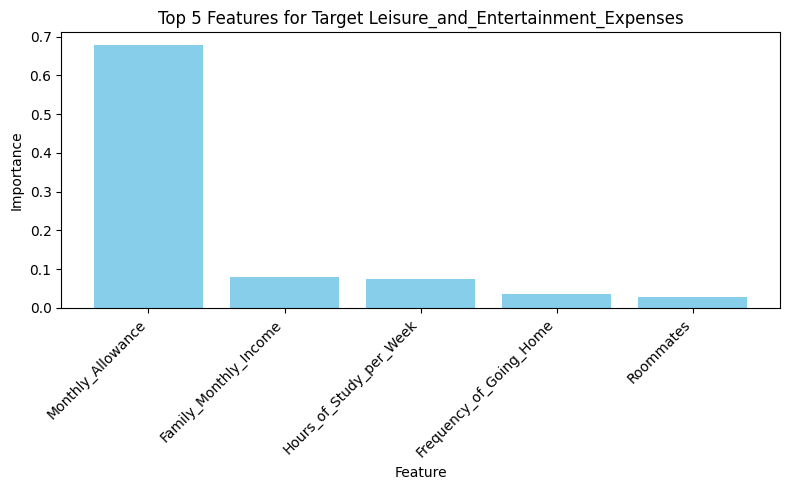

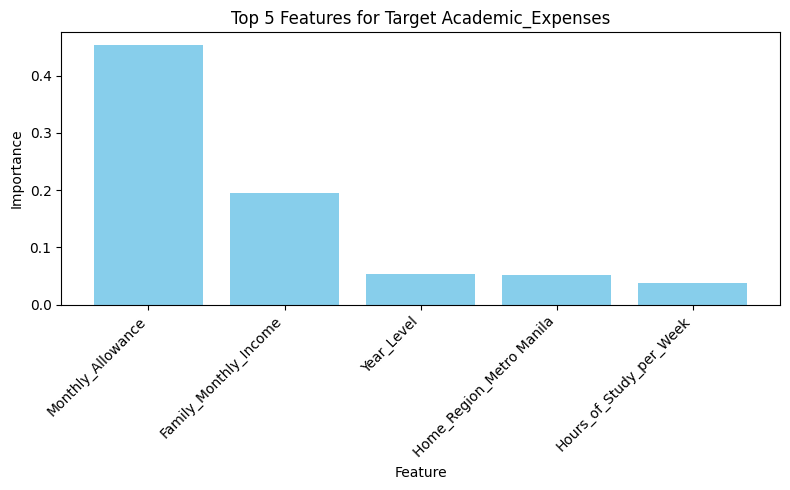

In [7]:

for i, estimator in enumerate(multioutput_regressor.estimators_):
    importances = estimator.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head()

    plt.figure(figsize=(8, 5))
    plt.bar(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title(f"Top 5 Features for Target {expense_cols[i]}")
    plt.tight_layout()
    plt.show()


# 7. Save Model

In [8]:

# model_path = os.path.join(os.getcwd(), "SocioDemoRFModel.pkl")
# with open(model_path, 'wb') as f:
#     pickle.dump(multioutput_regressor, f)
# print("Model trained and saved successfully")
